In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import src.signal.signal as sgl

In [3]:
s = sgl.Signal()

In [4]:
noise = s._gaussian_noise(10)

<AxesSubplot:xlabel='Time (Seconds)'>

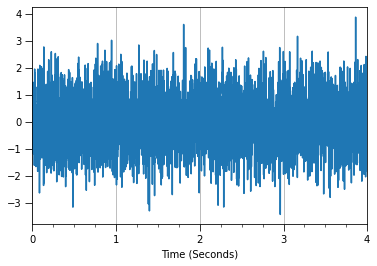

In [5]:
s.plot_signal(noise)

In [6]:
sig = s._sinusoid(10,3, 4,0)

<AxesSubplot:xlabel='Time (Seconds)'>

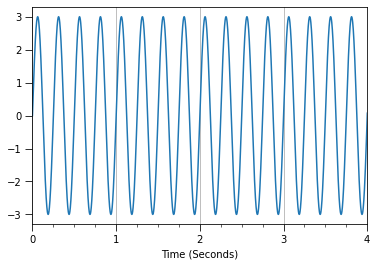

In [7]:
s.plot_signal(sig)

<AxesSubplot:xlabel='Time (Seconds)'>

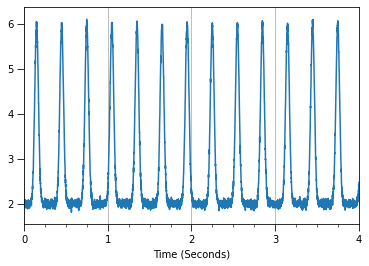

In [8]:
sig=s.sig_gen(0.3,pulse_height=4, bias=2, pulse_width=0.5)
s.plot_signal(sig)

<AxesSubplot:xlabel='Time (Seconds)'>

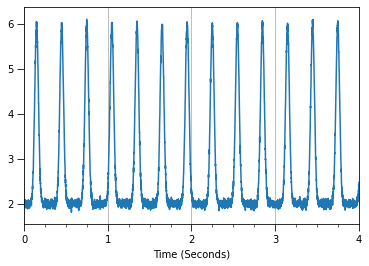

In [9]:
s.plot_signal(sig)

In [19]:
class Pulse():

    _pulsedefaults = { 'pulse_period': 0.7, 'pulse_width': 0.05, 'pulse_phase': np.pi,
        'pulse_peaks': True, 'pulse_height': 1.0,  'pulse_type': 'gaussian', 'pulse_sigma':1}

    _pulsetypes = ['square', 'left triangle', 'right triangle', 'triangle', 'gaussian']

    def __init__(self, **kwargs):
        #required properties
        for p in Pulse._pulsedefaults:
            setattr(self, p, kwargs.pop(p, Pulse._pulsedefaults[p]))

        #optional properties
        if len(kwargs) > 0:
            for p in ['name','description']:
                val = kwargs.pop(p, None)
                if val is not None:
                    setattr(self, p, val)
        
        if len(kwargs)>0:
            err_str = ', '.join([p for p in kwargs])
            raise ValueError(f'Unrecognized kwargs: {err_str}')

        if self.pulse_type not in Pulse._pulsetypes:
            err_str = f'Invalid pulsetype: {self.pulse_type}, valid pulsetypes are: '+', '.join(pulseprops._pulsetypes)
            raise ValueError(err_str)

        if self.pulse_phase < 0.0 or self.pulse_phase > 2*np.pi:
            raise ValueError('pulse phase must be between 0 and 2 pi')

    def __repr__(self):
        
        repr_str = ', '.join([f'{p}: {getattr(self,p)}' for p in ['name','description'] if hasattr(self,p)])
        if len(repr_str)> 0:
            repr_str += ', '
        repr_str += ', '.join([f'{p}: ' + str(getattr(self, p)) for p in Pulse._pulsedefaults])
        
        return repr_str


    def to_dict(self):
        #name value tuples of the optional and required properties
        nvpairs = [(p, getattr(self,p)) for p in ['name','description'] if hasattr(self,p)] +\
                    [(p,getattr(self, p)) for p in Pulse._pulsedefaults]

        d = dict(nvpairs)
        return d

    def _pulse_profile(self, pulse_length):
        """
        creates a single pulse centered in the pulse_length
        pulse_len is the number of samples that the pulse is to occupy.
        Pulse is centered in this interval
        """
        if self.pulse_type == 'square':
            pulse = np.ones(pulse_length)
        elif self.pulse_type == 'left triangle':
            pulse = np.linspace(1,0, pulse_length)
        elif self.pulse_type == 'right triangle':
            pulse = np.linspace(0,1, pulse_length)
        elif self.pulse_type == 'triangle':
            nleft = pulse_length//2
            nright = pulse_length-nleft
            pulse = np.concatenate([np.linspace(0,1, nleft, endpoint=False), np.linspace(1,0, nright)])
        elif self.pulse_type == 'gaussian':
            x = np.linspace(-10, 10, pulse_length)
            pulse = np.exp(-x**2/(2*(self.pulse_sigma**2)))
        else:
            raise ValueError(f'Invalid pulse_type: {self.pulse_type}')

        return pulse

    def pulse_signal(self, tsamp=1.0/1024.0, sigdur=300):

        total_samples = int(sigdur/tsamp) #total number of samples in returned signal
        samples_per_pulseperiod = int(self.pulse_period/tsamp)
        samples_per_pulse = int(samples_per_pulseperiod*self.pulse_width)
        padleft = (samples_per_pulseperiod-samples_per_pulse)//2
        padright = samples_per_pulseperiod - samples_per_pulse - padleft
        polarity = 1 if self.pulse_peaks else -1
        pulse = self.pulse_height*polarity*self._pulse_profile(samples_per_pulse)
        sig_period = np.pad(pulse, (padleft, padright)) # pulse is in the middle of the period (at pi radians)

        #adjust the phase
        pulse_radians_per_sample = 2*np.pi/samples_per_pulseperiod
        phi = self.pulse_phase - np.pi # radians to offset from middle of pulse period
        phase_offset = int(phi/pulse_radians_per_sample)
        sig_period = np.roll(sig_period, phase_offset)

        # string the periods together for the duration of the signal
        nperiods = total_samples//samples_per_pulseperiod #total number of whole pulses
        extra = total_samples - nperiods*samples_per_pulseperiod #number of samples from fractional pulse
        assert nperiods*len(sig_period)+extra == total_samples

        sig = np.concatenate([np.tile(sig_period, nperiods), sig_period[:extra]])
        print(f'Total samples: {total_samples}, Signal Length: {len(sig)}')
        assert len(sig)== total_samples

        return sig



In [20]:
Pulse(name='kevin').to_dict()

{'name': 'kevin',
 'pulse_period': 0.7,
 'pulse_width': 0.05,
 'pulse_phase': 3.141592653589793,
 'pulse_peaks': True,
 'pulse_height': 1.0,
 'pulse_type': 'gaussian',
 'pulse_sigma': 1}

In [21]:
pp = Pulse( pulse_peaks=False, pulse_type='right triangle')

In [22]:
zz=pp.pulse_signal()

Total samples: 307200, Signal Length: 307200


Total samples: 307200, Signal Length: 307200


<AxesSubplot:xlabel='Time (Seconds)'>

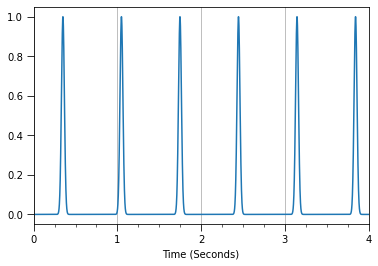

In [23]:
s.plot_signal(Pulse( pulse_peaks=True, pulse_width=0.5, pulse_type='gaussian').pulse_signal())

In [15]:
pp.pulse_period, pp.pulse_peaks

(0.7, False)

In [16]:
pp.to_dict()

{'pulse_period': 0.7,
 'pulse_width': 0.05,
 'pulse_phase': 3.141592653589793,
 'pulse_peaks': False,
 'pulse_height': 1.0,
 'pulse_type': 'right triangle',
 'pulse_sigma': 1}

In [17]:
[(p, getattr(pp,p)) for p in ['name','description'] if hasattr(pp,p)]

[]

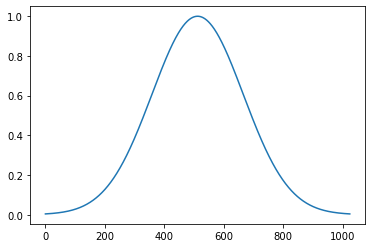

In [24]:
plt.plot(Pulse(pulse_type='gaussian', pulse_sigma=3)._pulse_profile(1024))